## Initializing Database

In [1]:
import numpy as np
import mygrad as mg

In [2]:
# run this cell to setup matplotlib, and also import the very important take_picture function from camera!
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import networkx as nx
import numpy as np
import cv2

from facenet_models import FacenetModel
from typing import List


In [3]:
def cos_distance(d_avg, d_test):
    d_avg_normalized = d_avg / np.linalg.norm(d_avg)
    d_test_normalized = d_test / np.linalg.norm(d_test)
    
    # print(d_avg_normalized)
    # print(d_test_normalized)
    
    numerator = np.dot(d_avg_normalized, d_test_normalized)
    d_avg_mag = np.sqrt(np.dot(d_avg_normalized, d_avg_normalized))
    d_test_mag = np.sqrt(np.dot(d_test_normalized, d_test_normalized))
    
    return 1 - numerator # / (d_avg_mag * d_test_mag)

In [4]:
class Profile:
    
    def __init__(self, name="", vector_descriptors=None):
        self.name = name # the name of the person
        if vector_descriptors is None:
            vector_descriptors = []
        self.vector_descriptors = vector_descriptors # the vector descriptors of each face of the person in the database
        self.averageVD = 0
        
    def addPic(self, pic_vd):
        self.vector_descriptors.append(pic_vd)
        self.calculateAverageVD() # Initialize average VD
        
    def removePic(self, index = 0):
        #if len(vector_desciptors) == 0:
        self.vector_descriptors.pop(index)
        self.calculateAverageVD()
    
    def calculateAverageVD(self): # Calculates the average vector descriptor of the person for 
        if len(self.vector_descriptors) == 0:
            self.averageVD = 0
        else:
            self.averageVD = np.sum(self.vector_descriptors, axis=0)/len(self.vector_descriptors)

In [5]:
class Database:
    
    def __init__(self):
        self.storage = dict() 
        self.entries = []
        self.model = FacenetModel()
    
    def addEntry(self, *, pic_vd, name):
        if name not in self.storage:
            profile = Profile(name=name)
            profile.addPic(pic_vd)
            self.storage[name] = profile
            self.entries.append(name)
        else:
            self.storage[name].addPic(pic_vd)
    
    def removeEntry(self, *, index, name):
        self.storage[name].removePic(index)
    
    def removeProfile(self, *, name):
        self.entries.remove(name)
        if name not in self.storage:
            print("Tried to delete a non-existent key-value pair in self.storage!")
            exit()
        del self.storage[name]
        
    def match(self, sample_vd, cutoff = 0.5):
        matched_name = ""
        lowest_score = 50
        for entry in self.entries:
            dist = cos_distance(sample_vd, self.storage[entry].averageVD)
            print("Cosine Similarity for", entry, ":", dist)
            if dist <= cutoff and dist < lowest_score:
                lowest_score = dist
                matched_name = entry
        if matched_name == "":
            return "No one!"
        else:
            return matched_name
        
    def convertFacetoVD(self, pic, boxes): # Make sure f
        descriptor = self.model.compute_descriptors(pic, boxes) # Producing the descriptor vector
        descriptor = descriptor.reshape(512)
        return descriptor
    
    def convertPictoFaces(self, pic):
        # detect all faces in an image
        # returns a tuple of (boxes, probabilities, landmarks)
        # assumes ``pic`` is a numpy array of shape (R, C, 3) (RGB is the last dimension)
        #
        # If N faces are detected then arrays of N boxes, N probabilities, and N landmark-sets
        # are returned.
        boxes, probabilities, landmarks = self.model.detect(pic)
        return boxes, probabilities, landmarks
    
    def drawFaces(self, pic, boxes, probabilities, landmarks):
        # SHOWING FACE RECTANGLES
        from matplotlib.patches import Rectangle

        fig, ax = plt.subplots()
        ax.imshow(pic)

        for box, prob, landmark in zip(boxes, probabilities, landmarks):
            # draw the box on the screen
            ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))

            # Get the landmarks/parts for the face in box d.
            # Draw the face landmarks on the screen.
            for i in range(len(landmark)):
                ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")

In [16]:
class Node:
    """ Describes a node in a graph, and the edges connected
        to that node."""

    def __init__(self, ID, neighbors, descriptor, truth=None, file_path=None):
        """
        Parameters
        ----------
        ID : int
            A unique identifier for this node. Should be a
            value in [0, N-1], if there are N nodes in total.

        neighbors : Sequence[int]
            The node-IDs of the neighbors of this node.

        descriptor : numpy.ndarray
            The shape-(512,) descriptor vector for the face that this node corresponds to.

        truth : Optional[str]
            If you have truth data, for checking your clustering algorithm,
            you can include the label to check your clusters at the end.
            If this node corresponds to a picture of Ryan, this truth
            value can just be "Ryan"

        file_path : Optional[str]
            The file path of the image corresponding to this node, so
            that you can sort the photos after you run your clustering
            algorithm
        """
        self.id = ID  # a unique identified for this node - this should never change

        # The node's label is initialized with the node's ID value at first,
        # this label is then updated during the whispers algorithm
        self.label = ID

        # (n1_ID, n2_ID, ...)
        # The IDs of this nodes neighbors. Empty if no neighbors
        self.neighbors = tuple(neighbors)
        self.descriptor = descriptor

        self.truth = truth
        self.file_path = file_path

def whispers_algorithm(adj_matrix: np.ndarray, nodes: List[Node], max_iters=1):
    '''
    adj_matrix: an adjacency matrix that consists of all images (N x N). This is
    used for the weighted sum.
    
    nodes: a list of Node objects. This is used to determine if a node has been visited
    and also allows us to change the label of a node and access its neighbors.
    '''
    N = len(nodes)
    visited = {}
    for _ in range(max_iters):
        while len(visited) < N:
            i = np.random.randint(0, N, size=1)[0]
            node = nodes[i]
            if node.id not in visited:
                weighted_sum_list = {}
                for i in node.neighbors:
                    neighbor = nodes[i]
                    if neighbor.label not in weighted_sum_list:
                        weighted_sum_list[neighbor.label] = adj_matrix[node.id][neighbor.id]
                    else:
                        weighted_sum_list[neighbor.label] += adj_matrix[node.id][neighbor.id]
                if weighted_sum_list:
                    max_weighted_sum = weighted_sum_list[max(weighted_sum_list, key=weighted_sum_list.get)]
                    potential_neighbors = [k for k,v in weighted_sum_list.items() if v == max_weighted_sum]
                    if potential_neighbors:
                        r = np.random.randint(0, len(potential_neighbors), size=1)[0]
                        label = nodes[potential_neighbors[r]].label

                        node.label = label
                visited[node.id] = True

def assess_success(nodes):
    correct_match = 0
    label_match_only = 0
    truth_match_only = 0
    
    for node_i in range(len(nodes)):
        if node_i + 1 < len(nodes):
            if nodes[node_i].label ==nodes[node_i + 1].label and nodes[node_i].truth == nodes[node_i + 1].truth: 
                correct_match += 1
            elif not nodes[node_i].label == nodes[node_i + 1].label and nodes[node_i].truth == nodes[node_i + 1].truth:
                truth_match_only += 1
            elif nodes[node_i].label == nodes[node_i + 1].label and not nodes[node_i].truth == nodes[node_i + 1].truth:
                label_match_only += 1
            else: 
                break
    
    pairwise_precision = correct_match / (correct_match + truth_match_only)
    pairwise_recall = correct_match / (correct_match + label_match_only)
    return pairwise_precision, pairwise_recall

def create_graph(db, threshold):
    descriptors_list = []
    names_list = []
    for key in db.storage.keys():
        descriptors_list += db.storage[key].vector_descriptors
        for i in range(len(db.storage[key].vector_descriptors)):
            names_list.append(db.storage[key].name)
        
    N = len(descriptors_list)
    nodes = []
    adj_matrix = np.zeros(shape=(N, N))

    for i in range(N):
        for k in range(i+1, N):
            dist = cos_distance(descriptors_list[i], descriptors_list[k])
            if dist < threshold and dist != 0:
                adj_matrix[i][k] = 1 / (dist**2)
                adj_matrix[k][i] = 1 / (dist**2)

    for i in range(N):
        neighbors = []
        for k in range(N):
            if adj_matrix[i][k] > 0:
                neighbors.append(k)
        truth = names_list[i]
        u = Node(i, neighbors, descriptors_list[i], truth)
        nodes.append(u)
    return (descriptors_list, adj_matrix, nodes)



<IPython.core.display.Javascript object>


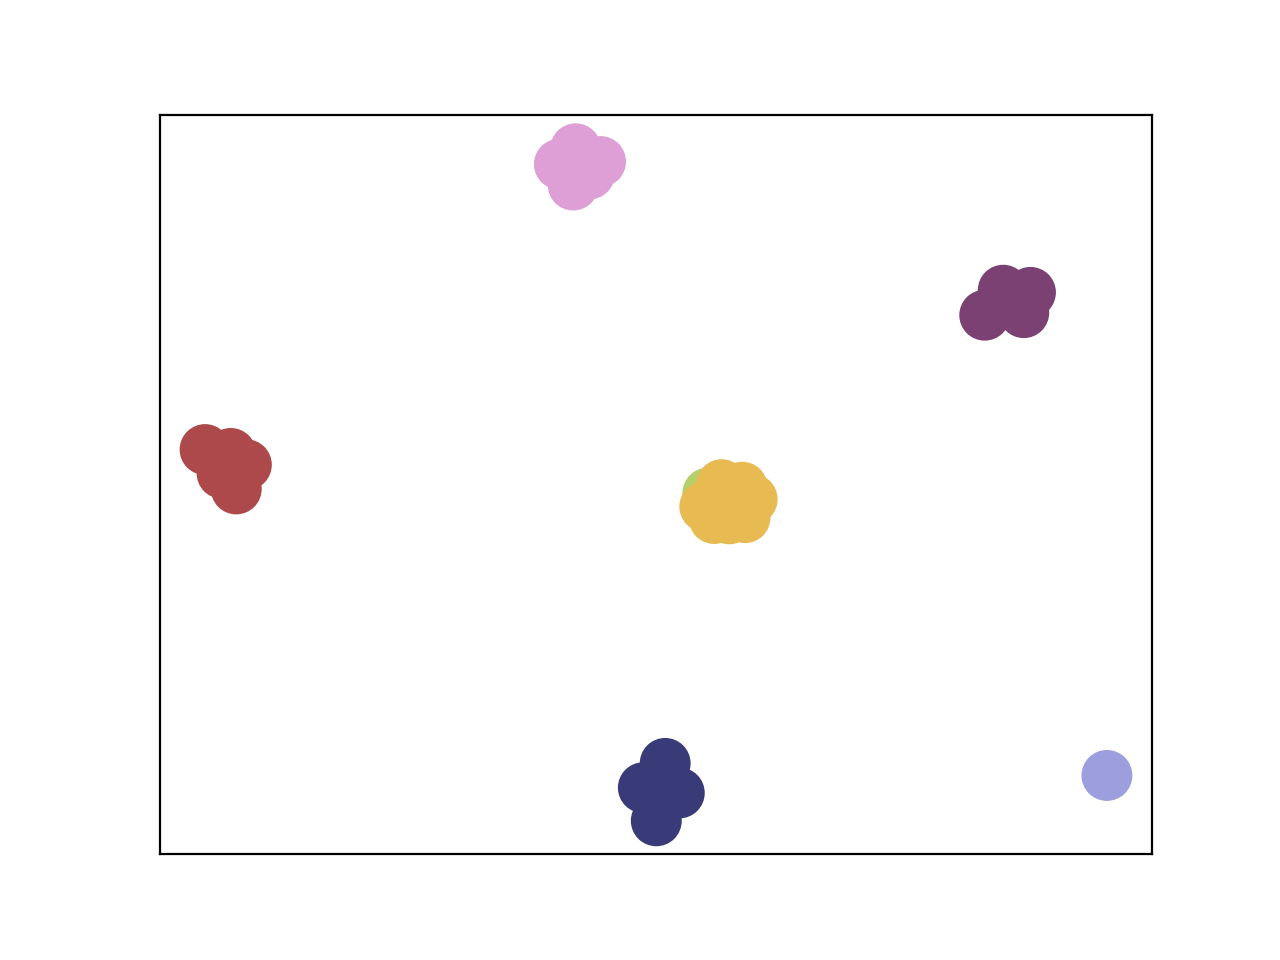

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [20]:
import networkx as nx
import matplotlib.cm as cm

def plot_graph(graph, adj):
    """ Use the package networkx to produce a diagrammatic plot of the graph, with
    the nodes in the graph colored according to their current labels.
    Note that only 20 unique colors are available for the current color map,
    so common colors across nodes may be coincidental.
    Parameters
    ----------
    graph : Tuple[Node, ...]
        The graph to plot. This is simple a tuple of the nodes in the graph.
        Each element should be an instance of the `Node`-class.

    adj : numpy.ndarray, shape=(N, N)
        The adjacency-matrix for the graph. Nonzero entries indicate
        the presence of edges.

    Returns
    -------
    Tuple[matplotlib.fig.Fig, matplotlib.axis.Axes]
        The figure and axes for the plot."""

    g = nx.Graph()
    for n, node in enumerate(graph):
        g.add_node(n)

    # construct a network-x graph from the adjacency matrix: a non-zero entry at adj[i, j]
    # indicates that an egde is present between Node-i and Node-j. Because the edges are
    # undirected, the adjacency matrix must be symmetric, thus we only look ate the triangular
    # upper-half of the entries to avoid adding redundant nodes/edges
    g.add_edges_from(zip(*np.where(np.triu(adj) > 0)))

    # we want to visualize our graph of nodes and edges; to give the graph a spatial representation,
    # we treat each node as a point in 2D space, and edges like compressed springs. We simulate
    # all of these springs decompressing (relaxing) to naturally space out the nodes of the graph
    # this will hopefully give us a sensible (x, y) for each node, so that our graph is given
    # a reasonable visual depiction
    pos = nx.spring_layout(g)

    # make a mapping that maps: node-lab -> color, for each unique label in the graph
    color = list(iter(cm.tab20b(np.linspace(0, 1, len(set(i.label for i in graph))))))
    color_map = dict(zip(sorted(set(i.label for i in graph)), color))
    colors = [color_map[i.label] for i in graph]  # the color for each node in the graph, according to the node's label

    # render the visualization of the graph, with the nodes colored based on their labels!
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, nodelist=range(len(graph)), node_color=colors)
    nx.draw_networkx_edges(g, pos, ax=ax, edgelist=g.edges())
    return fig, ax

plot_graph(nodes, adj_matrix)